# Actor-Critic (A2C)
Actor-Critic agents trains an actor network to learn a policy that selects actions, while simultaneously training a critic network to estimate the value function, guiding the actor towards actions that maximize expected rewards. This approach offers a balance between exploration and exploitation and enables efficient learning in complex environments.

In [14]:
import os
from datetime import datetime
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv, SubprocVecEnv, VecFrameStack, VecTransposeImage

## Create and train model

In [8]:
# Set path to logfile and model file:
root = './A2C/'


log_path = os.path.join(root, "LogFiles/")
log_name = datetime.now().strftime('%Y-%m-%d_%H-%M')
model_path = os.path.join(root, f"Models/model_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.zip")

print(type("./a2c_cartpole_tensorboard/"))
print(type(log_path))
print(log_name)
print(model_path)

<class 'str'>
<class 'str'>
2024-05-25_20-01
./A2C/Models/model_2024-05-25_20-01-51.zip


In [9]:
# Create multiples environments in parallel:
vec_env = make_vec_env("Humanoid-v4", n_envs=50)

# Initialize A2C model:
model = A2C("MlpPolicy", 
            vec_env, #"Humanoid-v4", #vec_env,
            device='cuda',
            verbose=1,
            tensorboard_log = log_path,

            # Tunning params:
            learning_rate = 3e-4,
            #n_steps = 2048,                 # Number of step for agent live
            use_rms_prop = True,            # Use RMSprop optimizer or Adam
            rms_prop_eps = 1e-5,            # Epsilon value used in RMSprop to avoid dividing by 0
            gamma = 0.99,                   # Decay factor, influence of future reward against current
            ent_coef = 0.01,                # Entropy: determin randomization in pdf of action to take (low value = deterministic, high value = stocastic)
            vf_coef = 0.5,                  # Relative importance of value function in training
            use_sde = False,                # SDE = State Dependent Exploration, include stochastic noice
            sde_sample_freq = -1,           # Frequency of sample a noise matrix (-1 = only sample at the begining of the rollout)
            normalize_advantage = True      # Normalize value function
)

# Training loop:
model.learn(total_timesteps=5e7, tb_log_name = log_name)

# Save model
model.save(model_path)

del model # remove to demonstrate saving and loading

Using cuda device
Logging to ./A2C/LogFiles/2024-05-25_20-01_1
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 21.7     |
|    ep_rew_mean        | 105      |
| time/                 |          |
|    fps                | 2382     |
|    iterations         | 100      |
|    time_elapsed       | 10       |
|    total_timesteps    | 25000    |
| train/                |          |
|    entropy_loss       | -24.2    |
|    explained_variance | 0.00809  |
|    learning_rate      | 0.0003   |
|    n_updates          | 99       |
|    policy_loss        | 0.107    |
|    std                | 1        |
|    value_loss         | 212      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 21.9     |
|    ep_rew_mean        | 107      |
| time/                 |          |
|    fps                | 1508     |
|    iterations         | 200      |
|    time_el

# Test

In [11]:
class WalkAgent:
    def __init__(self, test = False, plot=False):
        if test:
            rand_noise = np.random.uniform(0,0.1)
            self.env = gym.make("Humanoid-v4", reset_noise_scale = rand_noise)
            if plot:
                self.env = gym.make("Humanoid-v4", reset_noise_scale = rand_noise, render_mode="human")
        else:
            if plot:
                self.env = gym.make("Humanoid-v4", render_mode="human")
            else:
                self.env = gym.make("Humanoid-v4")

        observation, info = self.env.reset(seed=42)
        self.state = observation
        self.reward = 0
        self.is_alive = True
        self.time_alive = 0
        self.goal = False
        self.show = plot

    def one_step(self, action):
        observation, reward, terminated, truncated, info = self.env.step(action)
        self.time_alive += 1

        if terminated or truncated:
            observation, info = self.env.reset()

        self.state = observation
        self.reward = reward
        self.is_alive = not terminated
        self.goal = truncated

    def get_data(self):
        return self.state

    def get_reward(self):
        return self.reward

    def get_alive(self):
        return self.is_alive

    def get_time_alive(self):
        return self.time_alive

    def render(self):
        if self.show:
            self.env.render()

    def shut_down(self):
        self.env.close()


In [12]:
def evaluate_agent(model,n_iter=500):
    fitness_list = []
    lenght_list = []
    for _ in range(n_iter):
        agent = WalkAgent(test=True, plot=False)
        fitness = 0
        while agent.get_alive():
            action, _states = model.predict(agent.get_data())
            #output = net.activate(agent.get_data())
            agent.one_step(action)
            fitness += agent.get_reward()
            agent.render()
        
        fitness_list.append(fitness)
        lenght_list.append(agent.get_time_alive())
        
        agent.shut_down()

    return fitness_list, lenght_list

In [13]:
test_path = "./A2C/Models/model_2024-05-25_20-01-51.zip"
model = A2C.load(test_path)


# Evaluate the best genome
fitness, time_alive = evaluate_agent(model,n_iter=500)

np.save('./A3C_Stats',np.array(fitness))

[431.44372537142493, 258.5835686636962, 193.04159648397035, 227.297240757602, 256.0152324807504, 243.74565616054085, 495.8706810688013, 306.2174707709994, 338.0104397769354, 529.3111131937292, 253.94718445364995, 642.3363323295605, 225.87022227789905, 223.55977485581388, 295.4544620909662, 568.1663550213133, 378.8449169471755, 500.3256037275946, 341.03551175472955, 354.625313528925, 419.22671162850617, 421.55425309524173, 263.1590276659452, 354.9451401527399, 239.6638958175989, 350.3131153899725, 246.39117243918776, 299.80704473085297, 440.27529533749816, 384.4380999746456, 350.915430141519, 463.793706854714, 249.8169561583945, 229.21764584870664, 289.6973604236655, 361.57476920151964, 344.90972566387865, 329.6505773300353, 457.6547186136955, 618.3742663203271, 277.1655824076885, 464.50014583674675, 279.8703766369518, 362.9843620802043, 221.09424399229383, 377.10880505640887, 349.8942847158115, 455.6009767060004, 343.0850789368889, 399.00534598141195, 277.986298774034, 404.995497933108

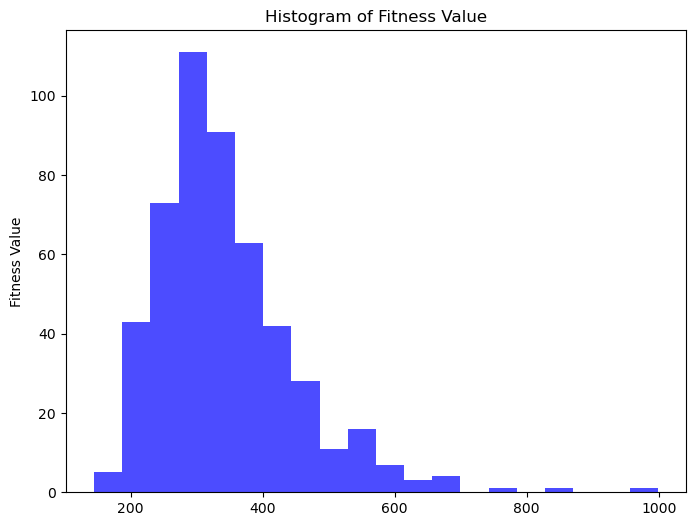

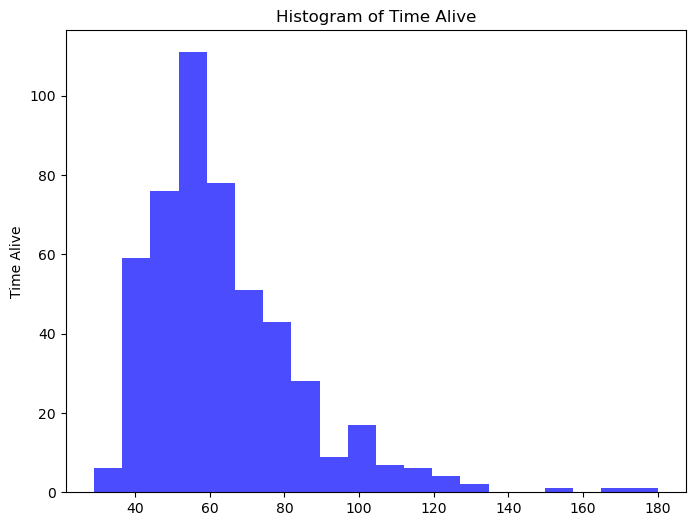

In [15]:
# Plot the result
# Fitness histogram
print(fitness)
plt.figure(figsize=(8, 6))  # Ancho x Alto en pulgadas
plt.hist(fitness, bins=20, color='blue', alpha=0.7)
plt.ylabel('Fitness Value')
plt.title('Histogram of Fitness Value')

# Time alive histogram
plt.figure(figsize=(8, 6))  # Ancho x Alto en pulgadas
plt.hist(time_alive, bins=20, color='blue', alpha=0.7)
plt.ylabel('Time Alive')
plt.title('Histogram of Time Alive')
plt.show()